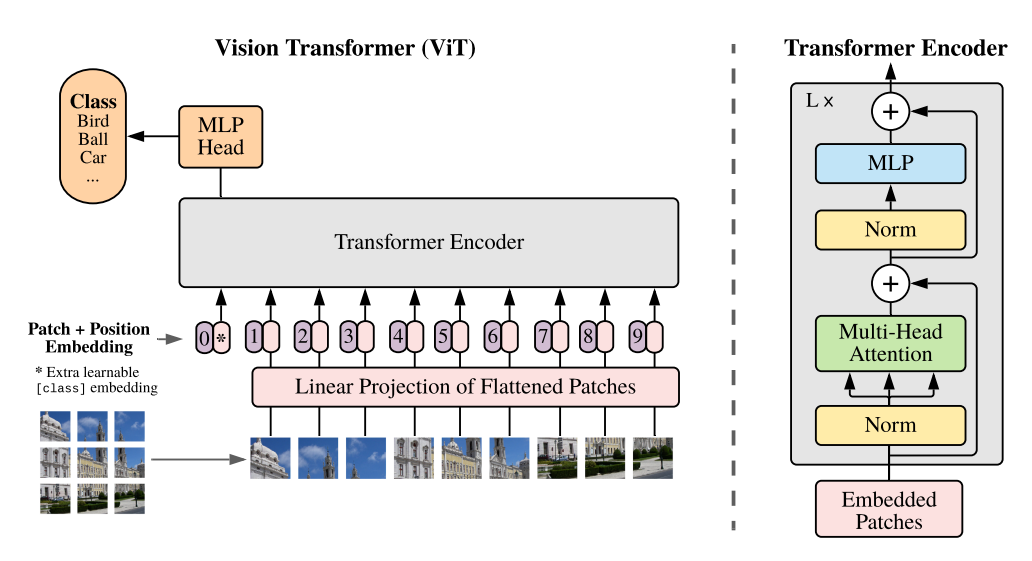

## 0) 준비: import + 초기화 유틸

목적

- ViT는 보통 가중치 초기화로 truncated normal(std=0.02) 관례를 씁니다.

- (엄밀 버전은 timm 라이브러리가 더 낫지만, 정리용으로 간단 구현)

$$
erf(x) = \frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^2} dt
$$

$$GELU(x) = x \cdot \Phi(x) = 0.5x \left(1 + erf\left(\frac{x}{\sqrt{2}}\right)\right)$$

In [11]:
import math
import torch
import torch.nn as nn

def trunc_normal_(tensor, mean=0.0, std=1.0, a=-2.0, b=2.0):
    # timm 스타일의 truncated normal 간단 구현
    # (엄밀한 구현이 필요하면 timm.trunc_normal_ 사용 권장)

    with torch.no_grad():
        l = 0.5 * (1.0 + math.erf((a - mean) / (std * math.sqrt(2.0)))) 
        u = 0.5 * (1.0 + math.erf((b - mean) / (std * math.sqrt(2.0))))
        tensor.uniform_(2 * l - 1, 2 * u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.0)).add_(mean)
        tensor.clamp_(min=a, max=b)
        return tensor

## 1) Patch Embedding: Patchify + Linear Projection

**논문 단계**

1. 이미지를 P×P 크기로 쪼개서 patch들을 만든다 (patchify)
2. 각 patch를 펼쳐서 (P×P×C)
3. Linear로 D차원 토큰으로 바꾼다

**구현 포인트**

- 실제 구현은 `Conv2d(kernel=P, stride=P)`가 위 3단계를 한 번에 수행합니다.
- 출력은 Transformer가 먹기 좋은 **(B, N, D)** 토큰 시퀀스입니다.

shape 흐름:

- 입력: (B, C, H, W)
- conv: (B, D, H/P, W/P)
- flatten: (B, N, D) where N=(H/P)(W/P)

In [3]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = (img_size, img_size) if isinstance(img_size, int) else img_size
        patch_size = (patch_size, patch_size) if isinstance(patch_size, int) else patch_size

        self.img_size = img_size
        self.patch_size = patch_size

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, \
            "img_size must be divisible by patch_size"

        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        # Conv2d로 patchify + linear projection 동시 수행
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, C, H, W)
        x = self.proj(x) # (B, D, H/P, W/P), N = H/P * W/P
        x = x.flatten(start_dim=2).transpose(1, 2) # (B, N, D) where N = num_patches, D = embed_dim
        return x

In [13]:
torch.randn((2, 3, 4, 4)).flatten(2).shape

torch.Size([2, 3, 16])

## 2) MLP(Feed Forward): Linear → GELU → Linear

**논문 단계**

- Transformer block의 FFN/MLP 부분
- hidden_dim = mlp_ratio * D (보통 4D)
- GELU 활성화

In [ ]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, x): # (B, N, D)
        x = self.fc1(x) # (B, N, 4D)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x) # (B, N, D)
        x = self.drop(x)
        return x

## 3) Multi-Head Self-Attention (MSA)

**논문 단계**

- 입력 토큰들에서 Q, K, V를 만들고
- scaled dot-product attention
- 여러 head로 나눠 병렬로 attention 후 concat

핵심 shape:

- 입력 x: (B, N, D)
- qkv: (B, N, 3D)
- q,k,v: (B, H, N, Dh) where Dh=D/H
- attn: (B, H, N, N)
- 출력: (B, N, D)

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=12, attn_dropout=0.0, proj_dropout=0.0):
        super().__init__()
        assert dim % num_heads == 0, \
        "embed_dim must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.attn_drop = nn.Dropout(attn_dropout)
        self.proj = nn.Linear(dim, dim) # W_O 역할
        self.proj_drop = nn.Dropout(proj_dropout)

    def forward(self, x):
        B, N, D = x.shape

        qkv = self.qkv(x) # (B, N, 3D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) # (3, B, H, N, Dh)
        q, k, v = qkv[0], qkv[1], qkv[2] # (B, H, N, Dh)

        attn = (q @ k.transpose(-2, -1)) * self.scale # (B, H, N, N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v # (B, H, N, Dh)
        out = out.transpose(1, 2).reshape(B, N, D)

        out = self.proj(out) # (B, N, D)
        out = self.proj_drop(out)
        return out

## 4) Transformer Encoder Block (Pre-LN + Residual)

**논문 블록 구조**

- Pre-LN (LayerNorm을 먼저)
- Residual 2번

수식:

- $x \leftarrow x + \text{MSA}(\text{LN}(x))$
- $x \leftarrow x + \text{MLP}(\text{LN}(x))$

In [9]:
class EncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.0, attn_dropout=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = MultiHeadSelfAttention(
            dim=dim, num_heads=num_heads, attn_dropout=attn_dropout, proj_dropout=dropout
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        self.mlp = MLP(dim=dim, hidden_dim=int(dim * mlp_ratio), dropout=dropout)
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

## 5) ViT 본체: [CLS] + PosEmbed + Encoder Stack + Head

**논문 전체 구조**

1. PatchEmbed로 (B, N, D)
2. 맨 앞에 학습 가능한 [CLS] 토큰 붙여서 (B, N+1, D)
3. Positional Embedding 더함
4. Encoder block을 depth만큼 반복
5. 마지막 LN
6. CLS 토큰만 뽑아서 분류 head로

In [12]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768,
                 depth=12, num_heads=12, mlp_ratio=4.0, dropout=0.0, attn_dropout=0.0):
        super().__init__()
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size,
            in_chans=in_chans, embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        # (1) CLS token, Positional Embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) # (1, 1, D)
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, embed_dim)) # (1, 1 + N, D), cat 때문에 1 + N
        self.pos_drop = nn.Dropout(dropout)

        # (2) Transformer Encoder Stack
        self.blocks = nn.ModuleList([
            EncoderBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout,
                attn_dropout=attn_dropout,
            )
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)

        # (3) Classification Head
        self.head = nn.Linear(embed_dim, num_classes)

        self._init_weights()

    def _init_weights(self):
        trunc_normal_(self.pos_embed, std=0.02)
        trunc_normal_(self.cls_token, std=0.02)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward_features(self, x):
        # 1) patches -> tokens
        x = self.patch_embed(x) # (B, N, D)

        # 2) prepend CLS
        B, N, D = x.shape
        cls = self.cls_token.expand(B, -1, -1) # (B, 1, D), expand()에서 -1은 원래 크기 유지
        x = torch.cat([cls, x], dim=1) # (B, 1 + N, D)

        # 3) add position
        x = x + self.pos_embed # (B, 1 + N, D)
        x = self.pos_drop(x)

        # 4) encoder blocks
        for blk in self.blocks:
            x = blk(x)

        # 5) final LN
        x = self.norm(x) # (B, 1 + N, D)

        # 6) take CLS token
        # self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))은 학습한 파라미터, cat 시 x 앞에 붙였음.
        return x[:, 0] # (B, D)
    
    def forward(self, x):
        feat = self.forward_features(x) # (B, D)

        # self.head = nn.Linear(embed_dim, num_classes)
        logits = self.head(feat) # (B, num_classes)
        return logits

## 6) 빠른 동작 확인(Shape 체크)

In [ ]:
model = VisionTransformer(
    img_size=224, patch_size=16, in_chans=3,
    num_classes=1000, embed_dim=768, depth=12, num_heads=12,
    mlp_ratio=4.0, dropout=0.1, attn_dropout=0.0
)

x = torch.randn(2, 3, 224, 224)
y = model(x)
print("logits:", y.shape)  # (2, 1000)

logits: torch.Size([2, 1000])


In [16]:
y[0].argmax(), y[1].argmax()

(tensor(562), tensor(943))

In [17]:
y[0][562], y[1][943]

(tensor(2.0412, grad_fn=<SelectBackward0>),
 tensor(1.9308, grad_fn=<SelectBackward0>))

In [18]:
y[0][560: 563]

tensor([-0.2488, -0.5623,  2.0412], grad_fn=<SliceBackward0>)

## Positional Embedding 보간(interpolate) 로직

### 왜 필요하냐

ViT는 `pos_embed`를 (1, 1+N, D)로 **학습 가능한 파라미터**로 갖고 있고, 여기서 N은 **학습 때의 패치 개수**에 고정됩니다.

- 예: 224×224, patch=16이면 N=196 → pos_embed shape = (1, 197, D)

그런데 추론/파인튜닝에서 해상도를 바꾸면:

- 예: 384×384, patch=16이면 N=576 → (1, 577, D)가 필요

그래서 **기존 pos_embed의 patch 부분만 2D로 reshape해서 bilinear로 보간**한 뒤 다시 펼칩니다.

- **[CLS] 위치는 보간하지 않고 그대로 유지**
- **patch pos만 보간**

### 코드: `interpolate_pos_encoding` + forward에서 적용

아래 코드를 `VisionTransformer` 클래스 안에 붙이면 됩니다.

<br>

```python
import torch.nn.functional as F

class VisionTransformer(nn.Module):
    # ... (기존 __init__ 그대로)

    def interpolate_pos_encoding(self, x, w, h):
        """
        x: (B, 1+N_new, D)  (CLS 붙인 뒤의 토큰)
        w,h: 입력 이미지의 width,height (또는 feature map 기준으로 계산 가능)
        """
        # 기존 pos_embed: (1, 1+N_old, D)
        N_new = x.shape[1] - 1
        N_old = self.pos_embed.shape[1] - 1
        D = self.pos_embed.shape[2]

        if N_new == N_old:
            return self.pos_embed

        # 1) CLS / patch pos 분리
        cls_pos = self.pos_embed[:, :1]      # (1, 1, D)
        patch_pos = self.pos_embed[:, 1:]    # (1, N_old, D)

        # 2) old grid 크기 추정 (정사각 패치 그리드 가정)
        gs_old = int(math.sqrt(N_old))
        assert gs_old * gs_old == N_old, "pos_embed patch tokens must form a square"

        # 3) new grid 크기 계산: (H/P, W/P)
        # patch_embed의 stride=patch_size라서 토큰 수는 (H/P)*(W/P)
        gs_h = h // self.patch_embed.proj.stride[0]
        gs_w = w // self.patch_embed.proj.stride[1]
        assert gs_h * gs_w == N_new, "Token count mismatch. Check input size / patch size."

        # 4) (1, N_old, D) -> (1, D, gs_old, gs_old)
        patch_pos = patch_pos.reshape(1, gs_old, gs_old, D).permute(0, 3, 1, 2)

        # 5) bilinear interpolate -> (1, D, gs_h, gs_w)
        patch_pos = F.interpolate(
            patch_pos, size=(gs_h, gs_w),
            mode="bilinear", align_corners=False
        )

        # 6) (1, D, gs_h, gs_w) -> (1, N_new, D)
        patch_pos = patch_pos.permute(0, 2, 3, 1).reshape(1, gs_h * gs_w, D)

        # 7) CLS 다시 붙이기
        new_pos_embed = torch.cat((cls_pos, patch_pos), dim=1)  # (1, 1+N_new, D)
        return new_pos_embed

    def forward_features(self, x):
        B, C, H, W = x.shape

        x = self.patch_embed(x)  # (B, N, D)

        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)  # (B, 1+N, D)

        # ✅ 여기서 pos_embed를 "현재 입력 해상도"에 맞춰 보간
        pos_embed = self.interpolate_pos_encoding(x, W, H)
        x = x + pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]
```

> 참고: 이 방식은 DINO/DeiT 계열 구현에서 흔히 쓰는 정석 패턴입니다. (논문 ViT 자체는 “정해진 해상도”로 많이 돌렸고, 파인튜닝/전이에서 보간이 사실상 필수가 됐습니다.)
>